In [1]:
# 1️⃣ Clone repo về
!git clone https://github.com/Vietchemistryyy/Fake_News_Detection_BERT.git

# 2️⃣ Chuyển vào thư mục repo
%cd Fake_News_Detection_BERT

# 3️⃣ Kiểm tra thư mục src có tồn tại
!ls

Cloning into 'Fake_News_Detection_BERT'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 146 (delta 73), reused 107 (delta 41), pack-reused 0 (from 0)
Receiving objects: 100% (146/146), 7.73 MiB | 27.19 MiB/s, done.
Resolving deltas: 100% (73/73), done.
/content/Fake_News_Detection_BERT
data		      models	 README.md	   results  src
FakeNewDetection2025  notebooks  requirements.txt  scripts  tests


In [2]:
# CELL 1: Environment Test & Setup
# ============================================================================
print("="*80)
print("ENVIRONMENT SETUP & VERIFICATION")
print("="*80)

import sys
sys.path.append('..')

# Test basic imports
try:
    import transformers
    print(f"✅ Transformers version: {transformers.__version__}")

    from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
    print("✅ Core transformers imports successful")

    # Test tokenizer
    test_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    print("✅ Tokenizer test successful")

    # Import project modules
    from src.config import ModelConfig, DataConfig
    from src.train import TRANSFORMERS_AVAILABLE, EARLY_STOPPING_AVAILABLE

    print(f"✅ TRANSFORMERS_AVAILABLE: {TRANSFORMERS_AVAILABLE}")
    print(f"✅ EARLY_STOPPING_AVAILABLE: {EARLY_STOPPING_AVAILABLE}")
    print("\n🎉 Environment ready for training!")

except ImportError as e:
    print(f"❌ Import error: {e}")
    print("\n💡 Installing required packages...")
    import subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q',
                          'transformers', 'accelerate', 'datasets'])
    print("✅ Packages installed. Please restart kernel and run again.")
    raise


ENVIRONMENT SETUP & VERIFICATION
✅ Transformers version: 4.57.1
✅ Core transformers imports successful


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

✅ Tokenizer test successful
✅ Transformers 4.57.1 loaded successfully
✅ EarlyStoppingCallback available
✅ TRANSFORMERS_AVAILABLE: True
✅ EARLY_STOPPING_AVAILABLE: True

🎉 Environment ready for training!


# ============================================================================
# NOTEBOOK 04: BERT MODEL TRAINING
# ============================================================================

## 🎯 Objective
Fine-tune a BERT model for fake news detection and compare performance with the baseline model.

## 📋 What we'll do:
1. **Load preprocessed data** from notebook 02
2. **Prepare PyTorch datasets** for BERT training
3. **Fine-tune BERT model** using Hugging Face Transformers
4. **Evaluate performance** on train/val/test sets
5. **Compare with baseline** model performance
6. **Save model** and results

---


In [3]:
# CELL 2: Complete Imports
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import warnings
warnings.filterwarnings('ignore')

from transformers import AutoTokenizer

# Import all required modules
from src.config import (
    DataConfig, ModelConfig, TrainingConfig,
    PROCESSED_DATA_DIR, METRICS_DIR, VISUALIZATIONS_DIR, MODELS_DIR
)
from src.dataset import create_dataset_from_dataframe
from src.train import BertTrainer, save_training_results
from src.evaluate import (
    compute_extended_metrics,
    plot_confusion_matrix,
    plot_roc_curve,
    compare_models,
    save_evaluation_results
)
from src.utils import save_json

# Setup
plt.style.use('default')
sns.set_palette("husl")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("="*80)
print("IMPORTS COMPLETED")
print("="*80)
print(f"🖥️  Device: {device}")
print(f"🤖 Model: {ModelConfig.MODEL_NAME}")
print(f"📊 Ready to train!")
print("="*80)

IMPORTS COMPLETED
🖥️  Device: cuda
🤖 Model: roberta-base
📊 Ready to train!


In [7]:
from google.colab import drive
drive.mount('/content/drive')

# Giả sử dữ liệu nằm ở:
# /content/drive/MyDrive/Fake_News_Detection_BERT/data/processed/
import os

# Chuyển đường dẫn trong DataConfig
DataConfig.TRAIN_PATH = '/content/drive/MyDrive/Fake_News_Detection_BERT/data/processed/train.csv'
DataConfig.VAL_PATH = '/content/drive/MyDrive/Fake_News_Detection_BERT/data/processed/val.csv'
DataConfig.TEST_PATH = '/content/drive/MyDrive/Fake_News_Detection_BERT/data/processed/test.csv'

# Kiểm tra tồn tại
print(os.path.exists(DataConfig.TRAIN_PATH))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
True


In [8]:
# CELL 3: Load Data
# ============================================================================
print("="*80)
print("LOADING PREPROCESSED DATA")
print("="*80)

# Load datasets
train_df = pd.read_csv(DataConfig.TRAIN_PATH)
val_df = pd.read_csv(DataConfig.VAL_PATH)
test_df = pd.read_csv(DataConfig.TEST_PATH)

print(f"\n📊 Data loaded successfully:")
print(f"   Train: {train_df.shape[0]:>7,} samples")
print(f"   Val:   {val_df.shape[0]:>7,} samples")
print(f"   Test:  {test_df.shape[0]:>7,} samples")
print(f"   Total: {(train_df.shape[0] + val_df.shape[0] + test_df.shape[0]):>7,} samples")

# Check label distribution
print(f"\n📈 Label distribution:")
for name, df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    fake_pct = (df['label'] == 1).sum() / len(df) * 100
    print(f"   {name:5} - Fake: {fake_pct:5.2f}%, Real: {100-fake_pct:5.2f}%")


LOADING PREPROCESSED DATA

📊 Data loaded successfully:
   Train:  95,244 samples
   Val:    20,409 samples
   Test:   20,410 samples
   Total: 136,063 samples

📈 Label distribution:
   Train - Fake: 46.90%, Real: 53.10%
   Val   - Fake: 46.90%, Real: 53.10%
   Test  - Fake: 46.90%, Real: 53.10%


In [9]:
# CELL 4: Load Tokenizer
# ============================================================================
print("="*80)
print("LOADING TOKENIZER")
print("="*80)

tokenizer = AutoTokenizer.from_pretrained(ModelConfig.MODEL_NAME)

print(f"\n🔤 Tokenizer: {ModelConfig.MODEL_NAME}")
print(f"   Vocab size: {tokenizer.vocab_size:,}")
print(f"   Max length: {ModelConfig.MAX_LENGTH}")
print(f"   Padding: {ModelConfig.PADDING}")
print(f"   Truncation: {ModelConfig.TRUNCATION}")

# Test tokenization
sample_text = train_df.iloc[0]['cleaned_content']
sample_tokens = tokenizer.encode(sample_text, max_length=ModelConfig.MAX_LENGTH, truncation=True)

print(f"\n🧪 Tokenization test:")
print(f"   Input length: {len(sample_text)} chars")
print(f"   Output length: {len(sample_tokens)} tokens")
print(f"   First 10 tokens: {sample_tokens[:10]}")


LOADING TOKENIZER


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


🔤 Tokenizer: roberta-base
   Vocab size: 50,265
   Max length: 256
   Padding: max_length
   Truncation: True

🧪 Tokenization test:
   Input length: 85 chars
   Output length: 26 tokens
   First 10 tokens: [0, 642, 718, 5992, 32, 6749, 154, 31, 821, 7043]


In [10]:
# CELL 5: Create PyTorch Datasets
# ============================================================================
print("="*80)
print("CREATING PYTORCH DATASETS")
print("="*80)

# Create datasets with proper error handling
try:
    train_dataset = create_dataset_from_dataframe(train_df, tokenizer)
    val_dataset = create_dataset_from_dataframe(val_df, tokenizer)
    test_dataset = create_dataset_from_dataframe(test_df, tokenizer)

    print(f"\n✅ Datasets created successfully:")
    print(f"   Train: {len(train_dataset):,} samples")
    print(f"   Val:   {len(val_dataset):,} samples")
    print(f"   Test:  {len(test_dataset):,} samples")

    # Verify dataset structure
    sample = train_dataset[0]
    print(f"\n🔍 Dataset structure:")
    print(f"   input_ids shape: {sample['input_ids'].shape}")
    print(f"   attention_mask shape: {sample['attention_mask'].shape}")
    print(f"   labels: {sample['labels'].item()}")

except Exception as e:
    print(f"❌ Error creating datasets: {e}")
    raise

CREATING PYTORCH DATASETS

✅ Datasets created successfully:
   Train: 95,244 samples
   Val:   20,409 samples
   Test:  20,410 samples

🔍 Dataset structure:
   input_ids shape: torch.Size([256])
   attention_mask shape: torch.Size([256])
   labels: 1


In [11]:
# CELL 6: Initialize Trainer
# ============================================================================
print("="*80)
print("INITIALIZING TRAINER")
print("="*80)

# Create output directory
output_dir = MODELS_DIR / "roberta"
output_dir.mkdir(parents=True, exist_ok=True)

# Initialize trainer
bert_trainer = BertTrainer(
    model_name=ModelConfig.MODEL_NAME,
    output_dir=str(output_dir)
)

print(f"✅ Trainer initialized:")
print(f"   Model: {ModelConfig.MODEL_NAME}")
print(f"   Output: {output_dir}")


INITIALIZING TRAINER
✅ Trainer initialized:
   Model: roberta-base
   Output: /content/Fake_News_Detection_BERT/models/roberta


In [12]:
# CELL 7: Train Model
# ============================================================================
print("="*80)
print("TRAINING MODEL")
print("="*80)

# Display training configuration
print(f"\n⚙️  Training Configuration:")
print(f"   Epochs: {ModelConfig.NUM_EPOCHS}")
print(f"   Batch size: {ModelConfig.BATCH_SIZE}")
print(f"   Learning rate: {ModelConfig.LEARNING_RATE}")
print(f"   Warmup steps: {ModelConfig.WARMUP_STEPS}")
print(f"   Weight decay: {ModelConfig.WEIGHT_DECAY}")
print(f"   Device: {device}")
print(f"   FP16: {TrainingConfig.USE_FP16 and torch.cuda.is_available()}")

# Train the model
print(f"\n🚀 Starting training...\n")

try:
    train_results = bert_trainer.train(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        num_epochs=ModelConfig.NUM_EPOCHS,
        batch_size=ModelConfig.BATCH_SIZE,
        learning_rate=ModelConfig.LEARNING_RATE,
        warmup_steps=ModelConfig.WARMUP_STEPS,
        weight_decay=ModelConfig.WEIGHT_DECAY
    )

    print("\n✅ Training completed successfully!")

except Exception as e:
    print(f"\n❌ Training failed: {e}")
    raise

# Display training summary
print("\n" + "="*80)
print("TRAINING SUMMARY")
print("="*80)
print(f"⏱️  Training time: {train_results['training_time']:.2f}s ({train_results['training_time']/60:.2f}m)")
print(f"\n📊 Final validation metrics:")
for k, v in train_results['eval_metrics'].items():
    if isinstance(v, (int, float)):
        print(f"   {k:20}: {v:.4f}")

TRAINING MODEL

⚙️  Training Configuration:
   Epochs: 3
   Batch size: 16
   Learning rate: 2e-05
   Warmup steps: 500
   Weight decay: 0.01
   Device: cuda
   FP16: True

🚀 Starting training...



model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.126600,0.120149,0.921358,0.931212,0.921358,0.921293
2,0.127700,0.120266,0.923612,0.932267,0.923612,0.922849


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.126600,0.120149,0.921358,0.931212,0.921358,0.921293
2,0.127700,0.120266,0.923612,0.932267,0.923612,0.922849
3,0.097400,0.124320,0.922681,0.932564,0.922681,0.922616



✅ Training completed successfully!

TRAINING SUMMARY
⏱️  Training time: 3815.04s (63.58m)

📊 Final validation metrics:
   eval_loss           : 0.1203
   eval_accuracy       : 0.9236
   eval_precision      : 0.9323
   eval_recall         : 0.9236
   eval_f1             : 0.9228
   eval_runtime        : 72.2257
   eval_samples_per_second: 282.5720
   eval_steps_per_second: 17.6670
   epoch               : 3.0000


In [13]:
# CELL 8: Evaluate on Test Set
# ============================================================================
print("="*80)
print("TEST SET EVALUATION")
print("="*80)

try:
    # Evaluate
    test_results = bert_trainer.evaluate(test_dataset)

    print("\n✅ Test evaluation completed!")
    print(f"\n📊 Test metrics:")
    for k, v in test_results.items():
        if isinstance(v, (int, float)):
            print(f"   {k:20}: {v:.4f}")

except Exception as e:
    print(f"❌ Evaluation failed: {e}")
    raise

TEST SET EVALUATION



✅ Test evaluation completed!

📊 Test metrics:
   eval_loss           : 0.1243
   eval_accuracy       : 0.9238
   eval_precision      : 0.9325
   eval_recall         : 0.9238
   eval_f1             : 0.9230
   eval_runtime        : 93.3656
   eval_samples_per_second: 218.6030
   eval_steps_per_second: 13.6670
   epoch               : 3.0000


In [14]:
# CELL 9: Get Detailed Predictions
# ============================================================================
print("="*80)
print("GENERATING PREDICTIONS")
print("="*80)

try:
    # Get predictions
    predictions = bert_trainer.trainer.predict(test_dataset)

    # Extract predictions and probabilities
    y_test_pred = np.argmax(predictions.predictions, axis=1)
    y_test_proba = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()
    y_test_true = test_df['label'].values

    print(f"\n✅ Predictions generated:")
    print(f"   Samples: {len(y_test_true):,}")
    print(f"   Predictions shape: {y_test_pred.shape}")
    print(f"   Probabilities shape: {y_test_proba.shape}")

    # Prediction distribution
    unique, counts = np.unique(y_test_pred, return_counts=True)
    print(f"\n📊 Prediction distribution:")
    for label, count in zip(unique, counts):
        label_name = "Real" if label == 0 else "Fake"
        pct = count / len(y_test_pred) * 100
        print(f"   {label_name}: {count:>6,} ({pct:5.2f}%)")

    # True label distribution
    unique, counts = np.unique(y_test_true, return_counts=True)
    print(f"\n📊 True label distribution:")
    for label, count in zip(unique, counts):
        label_name = "Real" if label == 0 else "Fake"
        pct = count / len(y_test_true) * 100
        print(f"   {label_name}: {count:>6,} ({pct:5.2f}%)")

except Exception as e:
    print(f"❌ Failed to generate predictions: {e}")
    raise


GENERATING PREDICTIONS



✅ Predictions generated:
   Samples: 20,410
   Predictions shape: (20410,)
   Probabilities shape: (20410, 2)

📊 Prediction distribution:
   Real: 12,325 (60.39%)
   Fake:  8,085 (39.61%)

📊 True label distribution:
   Real: 10,837 (53.10%)
   Fake:  9,573 (46.90%)


In [15]:
# CELL 10: Compute Extended Metrics
# ============================================================================
print("="*80)
print("COMPUTING EXTENDED METRICS")
print("="*80)

try:
    # Compute comprehensive metrics
    roberta_evaluation = compute_extended_metrics(
        y_true=y_test_true,
        y_pred=y_test_pred,
        y_proba=y_test_proba
    )

    # Add model name
    roberta_evaluation['model_name'] = f"RoBERTa ({ModelConfig.MODEL_NAME})"

    print("\n✅ Extended metrics computed!")
    print(f"\n📊 Complete evaluation results:")
    print(f"   Accuracy:  {roberta_evaluation['accuracy']:.4f}")
    print(f"   Precision: {roberta_evaluation['precision']:.4f}")
    print(f"   Recall:    {roberta_evaluation['recall']:.4f}")
    print(f"   F1-score:  {roberta_evaluation['f1']:.4f}")
    if 'roc_auc' in roberta_evaluation:
        print(f"   ROC-AUC:   {roberta_evaluation['roc_auc']:.4f}")
    if 'average_precision' in roberta_evaluation:
        print(f"   Avg Precision: {roberta_evaluation['average_precision']:.4f}")

    # Print classification report
    from sklearn.metrics import classification_report
    print(f"\n📋 Classification Report:")
    print(classification_report(y_test_true, y_test_pred,
                                target_names=['Real', 'Fake'],
                                digits=4))

except Exception as e:
    print(f"❌ Failed to compute metrics: {e}")
    raise


COMPUTING EXTENDED METRICS

✅ Extended metrics computed!

📊 Complete evaluation results:
   Accuracy:  0.9238
   Precision: 0.9325
   Recall:    0.9238
   F1-score:  0.9230
   ROC-AUC:   0.9876
   Avg Precision: 0.9864

📋 Classification Report:
              precision    recall  f1-score   support

        Real     0.8765    0.9969    0.9328     10837
        Fake     0.9958    0.8410    0.9119      9573

    accuracy                         0.9238     20410
   macro avg     0.9362    0.9189    0.9224     20410
weighted avg     0.9325    0.9238    0.9230     20410



CREATING VISUALIZATIONS

📊 Creating confusion matrix...


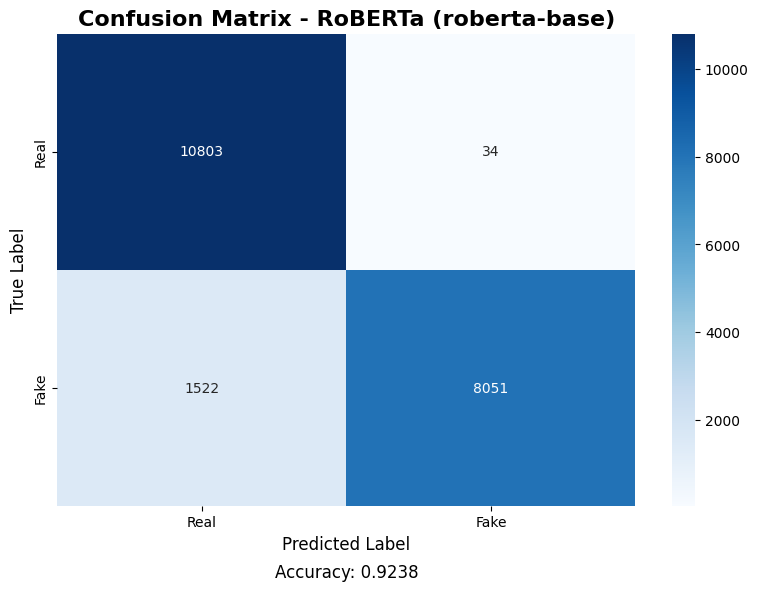

   ✅ Saved: /content/Fake_News_Detection_BERT/results/visualizations/roberta/confusion_matrix.png

📊 Creating ROC curve...


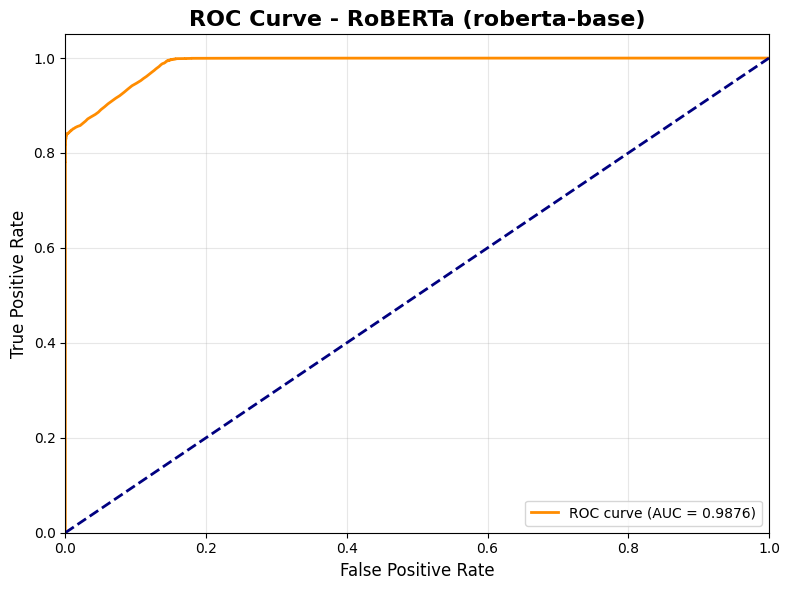

   ✅ Saved: /content/Fake_News_Detection_BERT/results/visualizations/roberta/roc_curve.png

✅ All visualizations created!


In [16]:
# CELL 11: Create Visualizations
# ============================================================================
print("="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

# Create visualization directory
viz_dir = VISUALIZATIONS_DIR / 'roberta'
viz_dir.mkdir(parents=True, exist_ok=True)

try:
    # Confusion Matrix
    print("\n📊 Creating confusion matrix...")
    plot_confusion_matrix(
        y_true=y_test_true,
        y_pred=y_test_pred,
        model_name=f"RoBERTa ({ModelConfig.MODEL_NAME})",
        save_path=viz_dir / "confusion_matrix.png"
    )
    print(f"   ✅ Saved: {viz_dir / 'confusion_matrix.png'}")

    # ROC Curve
    print("\n📊 Creating ROC curve...")
    plot_roc_curve(
        y_true=y_test_true,
        y_proba=y_test_proba,
        model_name=f"RoBERTa ({ModelConfig.MODEL_NAME})",
        save_path=viz_dir / "roc_curve.png"
    )
    print(f"   ✅ Saved: {viz_dir / 'roc_curve.png'}")

    print("\n✅ All visualizations created!")

except Exception as e:
    print(f"❌ Visualization failed: {e}")
    # Continue even if visualization fails


MODEL COMPARISON
✅ Baseline results loaded

📊 Creating comparison visualization...


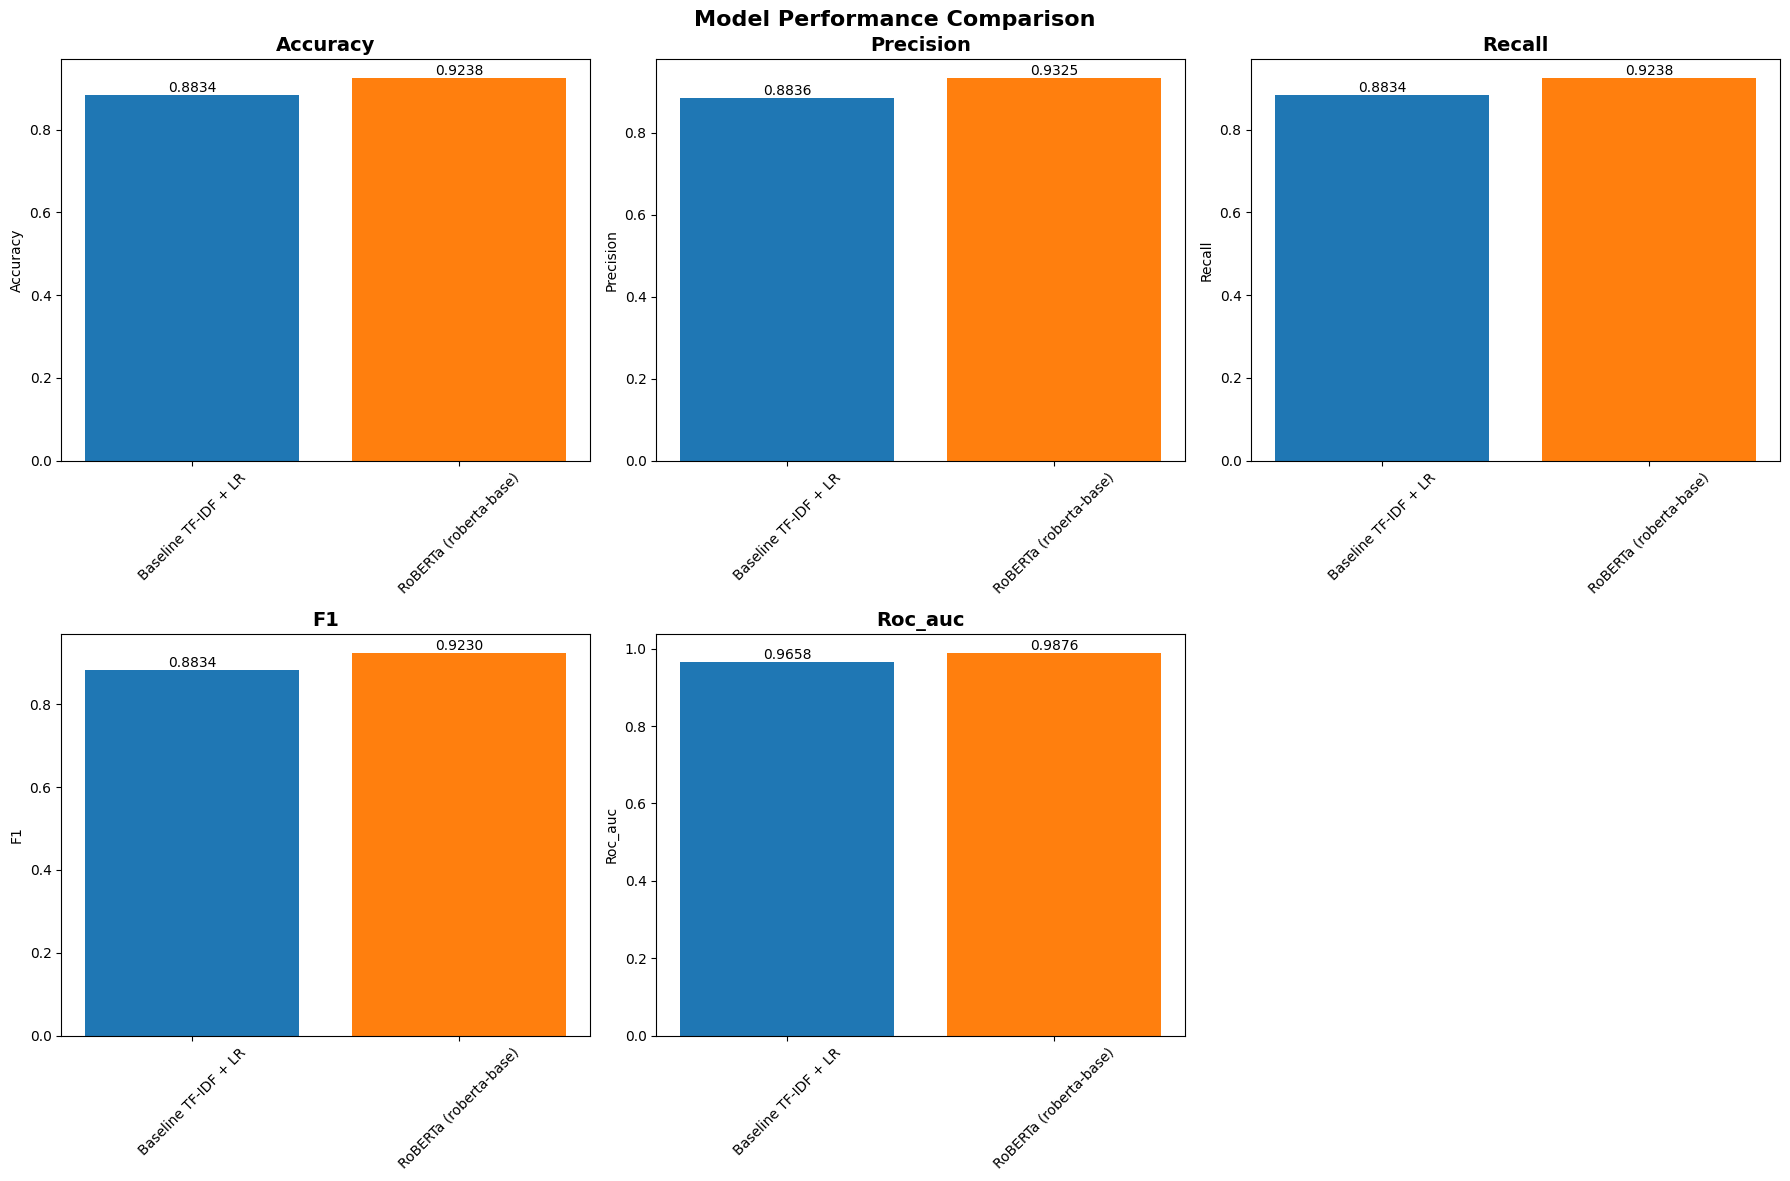


MODEL PERFORMANCE COMPARISON
                 Model  accuracy  precision  recall     f1  roc_auc
  Baseline TF-IDF + LR    0.8834     0.8836  0.8834 0.8834   0.9658
RoBERTa (roberta-base)    0.9238     0.9325  0.9238 0.9230   0.9876

🚀 Performance Improvements (RoBERTa vs Baseline):
   Accuracy       : 0.8834 → 0.9238 (+0.0404, +4.57%)
   Precision      : 0.8836 → 0.9325 (+0.0489, +5.53%)
   Recall         : 0.8834 → 0.9238 (+0.0404, +4.57%)
   F1             : 0.8834 → 0.9230 (+0.0396, +4.48%)
   Roc_auc        : 0.9658 → 0.9876 (+0.0219, +2.26%)


In [17]:
# CELL 12: Compare with Baseline
# ============================================================================
print("="*80)
print("MODEL COMPARISON")
print("="*80)

import json

try:
    # Try to load baseline results
    baseline_path = METRICS_DIR / "baseline_evaluation_results.json"

    if baseline_path.exists():
        with open(baseline_path, 'r') as f:
            baseline_evaluation = json.load(f)

        print("✅ Baseline results loaded")

        # Compare models
        print("\n📊 Creating comparison visualization...")
        comparison_df = compare_models(
            [baseline_evaluation, roberta_evaluation],
            save_path=viz_dir / "model_comparison.png"
        )

        # Calculate improvements
        metrics_to_compare = ['accuracy', 'precision', 'recall', 'f1']
        if 'roc_auc' in baseline_evaluation and 'roc_auc' in roberta_evaluation:
            metrics_to_compare.append('roc_auc')

        print(f"\n🚀 Performance Improvements (RoBERTa vs Baseline):")
        for metric in metrics_to_compare:
            if metric in baseline_evaluation and metric in roberta_evaluation:
                baseline_val = baseline_evaluation[metric]
                roberta_val = roberta_evaluation[metric]
                improvement = roberta_val - baseline_val
                pct_improvement = (improvement / baseline_val) * 100 if baseline_val > 0 else 0

                print(f"   {metric.capitalize():15}: {baseline_val:.4f} → {roberta_val:.4f} "
                      f"(+{improvement:.4f}, +{pct_improvement:.2f}%)")

    else:
        print("⚠️  Baseline results not found")
        print(f"   Looking for: {baseline_path}")
        print("   Skipping comparison")
        comparison_df = None

except Exception as e:
    print(f"⚠️  Comparison failed: {e}")
    comparison_df = None

In [18]:
# CELL 13: Save All Results
# ============================================================================
print("="*80)
print("SAVING RESULTS")
print("="*80)

# Create metrics directory
metrics_dir = METRICS_DIR / 'roberta'
metrics_dir.mkdir(parents=True, exist_ok=True)

try:
    # 1. Save evaluation results
    eval_path = metrics_dir / "evaluation_results.json"
    save_evaluation_results(roberta_evaluation, str(eval_path))
    print(f"✅ Evaluation: {eval_path}")

    # 2. Save training results
    train_path = metrics_dir / "training_results.json"
    save_training_results(train_results, str(train_path))
    print(f"✅ Training:   {train_path}")

    # 3. Save predictions
    predictions_data = {
        'y_true': y_test_true.tolist(),
        'y_pred': y_test_pred.tolist(),
        'y_proba': y_test_proba.tolist(),
        'model_name': f"RoBERTa ({ModelConfig.MODEL_NAME})",
        'num_samples': len(y_test_true),
        'num_correct': int((y_test_true == y_test_pred).sum()),
        'accuracy': float((y_test_true == y_test_pred).mean())
    }
    pred_path = metrics_dir / "test_predictions.json"
    save_json(predictions_data, pred_path)
    print(f"✅ Predictions: {pred_path}")

    # 4. Save model
    bert_trainer.save_model()
    print(f"✅ Model:      {output_dir}")

    print("\n✅ All results saved successfully!")

except Exception as e:
    print(f"❌ Failed to save results: {e}")
    raise


SAVING RESULTS
✅ Evaluation: /content/Fake_News_Detection_BERT/results/metrics/roberta/evaluation_results.json
✅ Training:   /content/Fake_News_Detection_BERT/results/metrics/roberta/training_results.json
Saved JSON to: /content/Fake_News_Detection_BERT/results/metrics/roberta/test_predictions.json
✅ Predictions: /content/Fake_News_Detection_BERT/results/metrics/roberta/test_predictions.json
✅ Model:      /content/Fake_News_Detection_BERT/models/roberta

✅ All results saved successfully!


In [19]:
# CELL 14: Final Summary
# ============================================================================
print("\n" + "="*80)
print("🎉 ROBERTA MODEL TRAINING COMPLETE!")
print("="*80)

print("\n✅ Completed Tasks:")
print("   ✓ Loaded and prepared data")
print("   ✓ Created PyTorch datasets")
print("   ✓ Fine-tuned RoBERTa model")
print("   ✓ Evaluated on test set")
print("   ✓ Generated predictions")
print("   ✓ Computed extended metrics")
print("   ✓ Created visualizations")
if comparison_df is not None:
    print("   ✓ Compared with baseline")
print("   ✓ Saved all results")

print(f"\n📊 Final Model Performance:")
print(f"   Model:     {ModelConfig.MODEL_NAME}")
print(f"   Device:    {device}")
print(f"   Accuracy:  {roberta_evaluation['accuracy']:.4f}")
print(f"   Precision: {roberta_evaluation['precision']:.4f}")
print(f"   Recall:    {roberta_evaluation['recall']:.4f}")
print(f"   F1-score:  {roberta_evaluation['f1']:.4f}")
if 'roc_auc' in roberta_evaluation:
    print(f"   ROC-AUC:   {roberta_evaluation['roc_auc']:.4f}")
print(f"   Training:  {train_results['training_time']:.2f}s")

print(f"\n📁 Output Locations:")
print(f"   Model:         {output_dir}")
print(f"   Metrics:       {metrics_dir}")
print(f"   Visualizations: {viz_dir}")

if comparison_df is not None:
    print(f"\n🚀 Best Performance Gains:")
    for metric in ['accuracy', 'f1']:
        if metric in roberta_evaluation and metric in baseline_evaluation:
            improvement = roberta_evaluation[metric] - baseline_evaluation[metric]
            print(f"   {metric.capitalize()}: +{improvement:.4f} (+{improvement*100:.2f}%)")

print("\n🎯 Next Steps:")
print("   → Deploy model to production")
print("   → Build FastAPI endpoint")
print("   → Create frontend interface")
print("   → Monitor model performance")

print("\n" + "="*80)
print("🎊 PROJECT READY FOR DEPLOYMENT!")
print("="*80)


🎉 ROBERTA MODEL TRAINING COMPLETE!

✅ Completed Tasks:
   ✓ Loaded and prepared data
   ✓ Created PyTorch datasets
   ✓ Fine-tuned RoBERTa model
   ✓ Evaluated on test set
   ✓ Generated predictions
   ✓ Computed extended metrics
   ✓ Created visualizations
   ✓ Compared with baseline
   ✓ Saved all results

📊 Final Model Performance:
   Model:     roberta-base
   Device:    cuda
   Accuracy:  0.9238
   Precision: 0.9325
   Recall:    0.9238
   F1-score:  0.9230
   ROC-AUC:   0.9876
   Training:  3815.04s

📁 Output Locations:
   Model:         /content/Fake_News_Detection_BERT/models/roberta
   Metrics:       /content/Fake_News_Detection_BERT/results/metrics/roberta
   Visualizations: /content/Fake_News_Detection_BERT/results/visualizations/roberta

🚀 Best Performance Gains:
   Accuracy: +0.0404 (+4.04%)
   F1: +0.0396 (+3.96%)

🎯 Next Steps:
   → Deploy model to production
   → Build FastAPI endpoint
   → Create frontend interface
   → Monitor model performance

🎊 PROJECT READY FOR D